In [41]:
import torch, torch_geometric as pyg, networkx as nx, pymimir as mi
from rgnet.encoding import ColorGraphEncoder

In [42]:
domain = mi.DomainParser("test/pddl_instances/blocks/domain.pddl").parse()
problem = mi.ProblemParser("test/pddl_instances/blocks/problem.pddl").parse(domain)
state_space = mi.StateSpace.new(problem, mi.GroundedSuccessorGenerator(problem))
state = state_space.get_initial_state()
graph = ColorGraphEncoder(domain).encode(state)

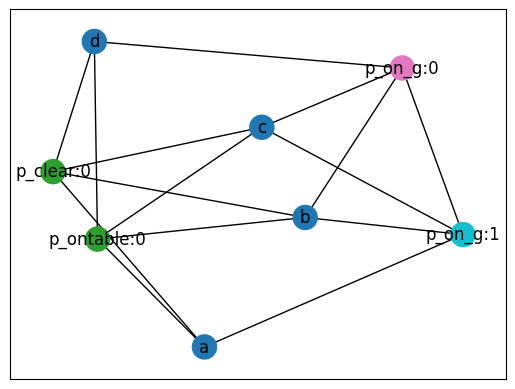

In [43]:
nx.draw_networkx(
    graph,
    with_labels=True,
    labels={n: str(n) for n in graph.nodes},
    nodelist=[n for n in graph.nodes],
    node_color=[attr["color"] for _, attr in graph.nodes.data()],
    cmap="tab10",
)

In [44]:
# In the from_networkx the graph is converted to a DiGraph. In the process it has to be pickled, which is not possible for pymimir.State
del graph.graph['state']
# Every node has to have the same features in order to be converted to y tensor
for node, attr in graph.nodes.data():
    if "info" in attr:
        del attr["info"]

In [45]:
data = pyg.utils.from_networkx(graph)
data

Data(edge_index=[2, 30], color=[8], num_nodes=8)

In [46]:
data.x = data['color'].float()  # the GCNLayer requires float-features

In [47]:
data.x

tensor([0., 0., 0., 0., 1., 1., 3., 5.])

In [48]:
from rgnet.model import PureGNN

In [49]:
model = PureGNN(in_channel=1, embedding_size=32, num_layer=4)
model.train()
out = model(data.x, data.edge_index,
            batch=torch.zeros(data.x.shape[0], dtype=torch.int64))  # batch assigns nodes to graphs

In [50]:
out

tensor([[0.6297]], grad_fn=<AddmmBackward0>)

In [51]:
from rgnet.supervised.data import MultiInstanceSupervisedSet

train_set = MultiInstanceSupervisedSet([problem], ColorGraphEncoder(domain))

In [52]:
train_set._data

Data(x=[1292, 1], edge_index=[2, 3886], y=[125], color=[1292], num_nodes=1292)